In [3]:
import numpy as np
import torch
from torch import nn
import pickle as pkl
import torch

from torch.optim import lr_scheduler
import torch.optim as optim

import os
import numpy as np
from networks import EmbeddingNet, TripletNetAdapted, TripletNetAdaptedText
from flickrDataSet import *
from matplotlib import pyplot as plt
from embeddings_utils import *
from tqdm import tqdm

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = 'TripletNet_taskA_2layerNet.pth'

In [5]:
def aggregation_text(word_embs, axis = 0):
    return np.sum(word_embs, axis=axis)

In [6]:
img_emb_dim = 4096
text_emb_dim = 300

embedding_net_img = EmbeddingNet(emd_dim=img_emb_dim)
embedding_net_text = EmbeddingNet(emd_dim=text_emb_dim)
model = TripletNetAdapted(embedding_net_img, embedding_net_text)
# model = TripletNetAdaptedText(embedding_net_img, embedding_net_text)


print('Loading model...')
model.load_state_dict(torch.load(model_path))
model.to(device)


Loading model...


TripletNetAdapted(
  (emb_net): EmbeddingNet(
    (fc1): Sequential(
      (0): Linear(in_features=4096, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ReLU()
    )
  )
  (text_net): EmbeddingNet(
    (fc1): Sequential(
      (0): Linear(in_features=300, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ReLU()
    )
  )
)

In [7]:
# Prepare the dataset
# train_data = FlickrDataset('./dataset/train_img_embs.pkl', './dataset/train_text_embs.pkl', aggregation=aggregation_text, train= True)
test_data = FlickrDataset('./dataset/test_img_embs.pkl', './dataset/test_text_embs.pkl', aggregation=aggregation_text, train= False)

(1000, 5)


In [8]:
color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
encoded_imgs = []
encoded_captions = []
all_embs = []
labels = []

for ind in range(len(test_data)):
    img, texts = test_data.getAllCaptions(ind)
    img_emb = model.get_embedding_img(torch.from_numpy(img).to(device)).data.cpu().numpy()
    encoded_imgs.append(img_emb)
    texts_embs = [model.get_embedding_text(torch.from_numpy(tx).to(device)).data.cpu().numpy() for tx in texts]
    encoded_captions.append(texts_embs)
    all_embs.append(img_emb)
    all_embs += texts_embs
    labels += [ind for i in range(1 + len(texts_embs))]

encoded_imgs = np.array(encoded_imgs)
encoded_captions = np.array(encoded_captions)

In [16]:
def compute_bestK(train_data, test_data, k=5, method=cv2.HISTCMP_BHATTACHARYYA, sortReverse=False):
    precs_per_image = []
    for ind, elem in tqdm(enumerate(test_data)):
        results = getDistances(method, train_data, elem[1])
        results = sorted([(v[1], v[0], k) for (k, v) in results.items()], reverse=sortReverse)
        precs_per_image.append((elem[0], [res[2] for res in results[:k]]))
        # classes = [res[1] for res in results[:k]]
        # precs_per_image.append(classes.count(elem['label']) / k)
    
    return precs_per_image

def embeddingsRawMap(embeddingsTxt, embeddingsImgs, labelsMap, captionsPerImage = 5):
    embeddingsLabelMap = []
    embeddingsImageMap = []
    i = 0
    for ind, emb in enumerate(embeddingsTxt):
        imageInd  = ind // captionsPerImage
        embeddingsLabelMap.append((labelsMap[imageInd]['sentences'][i]['raw'], labelsMap[imageInd]['filename'], emb))
        if i == 0:
            embeddingsImageMap.append((labelsMap[imageInd]['filename'], embeddingsImgs[imageInd]))
        i = (i + 1) % captionsPerImage

    return embeddingsImageMap, embeddingsLabelMap

In [11]:
np.shape(encoded_captions.reshape((5000, 128)))

(5000, 128)

In [12]:
import json
with open('dataset/test.json', 'rb') as op:
    textsMap = json.load(op)

embeddingsImageMap, embeddingsLabelMap = embeddingsRawMap(encoded_captions.reshape(5000,128), encoded_imgs, textsMap)

In [17]:
tests = [('Hellinger', cv2.HISTCMP_BHATTACHARYYA, False) ]#, ('Correlation', cv2.HISTCMP_CORREL, True), ('Chi Square', cv2.HISTCMP_CHISQR, False), ('Intersection', cv2.HISTCMP_INTERSECT, True)]
all_results_p1 = {}
preds_10 = None
for data in tests:
    print('Retrieval system with distance metric: ', data[0])
    preds_10 = compute_bestK(embeddingsLabelMap, embeddingsImageMap[:5],10,data[1],data[2])
#     prec_at_1 = np.mean([elem[1][0].count(elem[0]) for elem in preds_10])
#     prec_at_5 = np.mean([elem[1][:5].count(elem[0]) / 5 for elem in preds_10])
#     prec_at_10 = np.mean([elem[1][:10].count(elem[0]) / 10 for elem in preds_10])
#     all_results_p1[data[0]] = []
#     for i in range(1,11):
#         all_results_p1[data[0]].append(np.mean([elem[1][:i].count(elem[0]) / i for elem in preds_10]))
#     print(f'Prec@1: {prec_at_1}', f'Prec@5: {prec_at_5}', f'Prec@10: {prec_at_10}')

# for key, vals in all_results_p1.items():
#     plt.plot(list(range(1,len(vals) + 1)), vals, label=key)
# plt.legend()
# plt.show()


Retrieval system with distance metric:  Hellinger


5it [00:11,  2.33s/it]


In [18]:
print(preds_10)

[('1007129816.jpg', ['A man smoking a cigarette and wearing a NY baseball cap is looking down at a camera.', 'A man smoking a cigarette and wearing a yankees hat trying to operate a camera.', 'A British gentleman, dressed in full military uniform, waving his hat with a background of people sitting back and looking out onto the waterway.', 'Man in black hat sipping wine.', 'Man wearing red uniform holding a black hat in the air with his right hand.', 'An older man with a cigarette in his mouth and a ball cap inspects his camera.', 'Seated man with red hat and green shirt is talking on the phone.', 'A man wears an orange hat and glasses.', 'A young man in a blue poncho smoking a cigarette.', 'A man with a pensive look on his face shave off his beard.']), ('1009434119.jpg', ['A cat is looking down from on top of a sign.', 'A light brown dog jumps through a ring of fire while two people watch.', 'A dog goes through an obstacle course while his owner runs beside him.', 'A black dog sprints 

In [8]:
pca = PCA(n_components=3)
pca.fit(all_embs)

pca.explained_variance_ratio_

In [13]:
#doesn't work with all the samples, too heavy
from embeddings_utils import build_knn
knn = build_knn(all_embs, labels, 5)
print(100.0 * knn.score(all_embs,labels))

Error: Canceled future for execute_request message before replies were done

In [10]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.neighbors import KNeighborsClassifier

Y = label_binarize(labels, classes=[*range(len(test_data))])
Y_test = label_binarize(labels[:60], classes=[*range(len(test_data))])

print('Training One vs Rest...')
clf = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=8))
clf.fit(all_embs, Y)

print('Predicting probas...')
y_score = clf.predict_proba(all_embs[:60])

# precision recall curve
precision = dict()
recall = dict()
aps = []
print('Computing MAP...')
for i in range(len(test_data)):
    ap = average_precision_score(Y_test[:, i], y_score[:, i])
    aps.append(ap)
#     precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
#                                                         y_score[:, i])
#     plt.plot(recall[i], precision[i], lw=2, label=f'{mit_classes[i]} - {ap:.3f}')
print(np.mean(aps))
# plt.xlabel("recall")
# plt.ylabel("precision")
# plt.legend(loc="best")
# plt.title("precision vs. recall curve")
# plt.show()

Training One vs Rest...
Predicting probas...
Computing MAP...


ValueError: Found input variables with inconsistent numbers of samples: [6000, 60]

/home/group05/anaconda3/envs/M5env/lib/python3.7/site-packages/umap/spectral.py:261: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/group05/anaconda3/envs/M5env/lib/python3.7/site-packages/umap/spectral.py:261: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/group05/anaconda3/envs/M5env/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


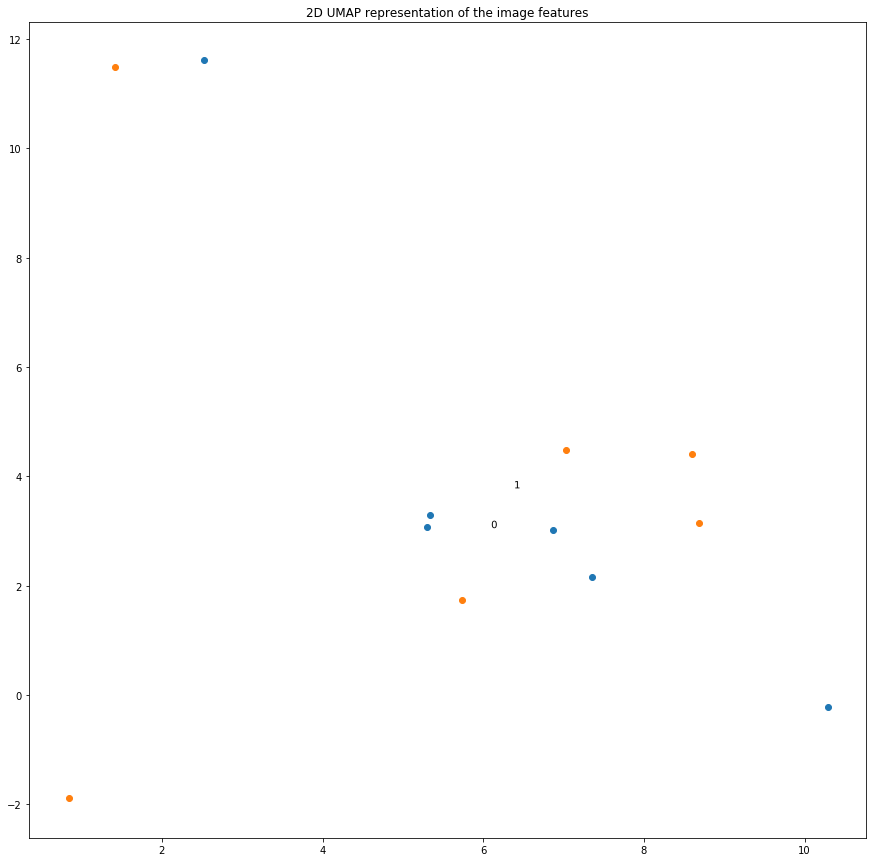

In [15]:
# #UMAP
# # compute the umap image representation
import umap.umap_ as umap
import matplotlib.patheffects as PathEffects

def plot_embeddings_umap(embeddings_cl, embeddings_to_plot, labels_cl):
        plt.figure(figsize=(15,15))
        umap_emb = umap.UMAP(n_neighbors=4, min_dist=0.3, metric='correlation')
        umap_emb.fit(embeddings_cl)
        embedding = umap_emb.transform(embeddings_to_plot)
        labels = np.unique(labels_cl)

        for idx, label in enumerate(labels):
            label_features = [embedding[i] for i, x in enumerate(labels_cl) if x == label]
            plt.scatter(
                [x[0] for x in label_features],
                [x[1] for x in label_features],
                c=np.array([color[idx]]),
                label=label,
                # s=np.ones(len(test_classes)),
            )

        # plt.legend(loc='best')

        for idx, label in enumerate(labels):
            label_features = [embedding[i] for i, x in enumerate(labels_cl) if x == label]
            xtext, ytext = np.median(label_features, axis=0)
            txt = plt.text(xtext, ytext, label)
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=5, foreground="w"),
                PathEffects.Normal()])

        plt.title('2D UMAP representation of the image features')
        plt.show()


plot_embeddings_umap(all_embs, all_embs[:12], labels[:12])